In [1]:
# Import dependencies and set plotting styles

%matplotlib inline

In [2]:
from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# Create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model

Base = automap_base()

In [7]:
# Reflect the tables

Base.prepare(engine, reflect=True) 

In [8]:
# View all of the classes that automap found

Base.classes.keys() 

['measurement', 'station']

In [9]:
# Save references to each table

Measurement = Base.classes.measurement

Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB

session = Session(engine) 

In [11]:
# Look at first row of each object as dict

first_row_M = session.query(Measurement).first()
first_row_M.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2544b6b8a60>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [12]:
first_row_S = session.query(Station).first()
first_row_S.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2544ffc4d30>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [13]:
# Date conversion functions

def convert_from_iso(obj):    
    return dt.date.fromisoformat(obj)
        
def convert_to_iso(obj):    
    return dt.date.toisoformat(obj)             

In [14]:
# Find the most recent date in the data set.

dates = session.query(Measurement.date)

max_date = convert_from_iso(max(dates)[0])
min_date = convert_from_iso(min(dates)[0])

print(f"Max date in dataset: {max_date}")
print(f"Min date in dataset: {min_date}")

Max date in dataset: 2017-08-23
Min date in dataset: 2010-01-01


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

from dateutil.relativedelta import relativedelta                 # thx to Tom! 

last_12_months = max_date - relativedelta(months=12)

print(last_12_months)

2016-08-23


In [16]:
# Calculate the date one year from the last date in data set.

plus_one_yr = max_date + relativedelta(years=1)

print(plus_one_yr)

2018-08-23


In [21]:
# Perform a query to retrieve the data and precipitation scores

precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_12_months).all()

In [34]:
# print(dict(precip))

In [23]:
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(data=precip)

df = df.set_index(keys=df["date"], drop=True)

df = df.drop(["date"], axis=1)

df = df.rename(columns={"prcp": "precipitation"})

# Sort the dataframe by date

df = df.sort_index(axis=0)

df

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


<AxesSubplot:xlabel='Date', ylabel='Inches'>

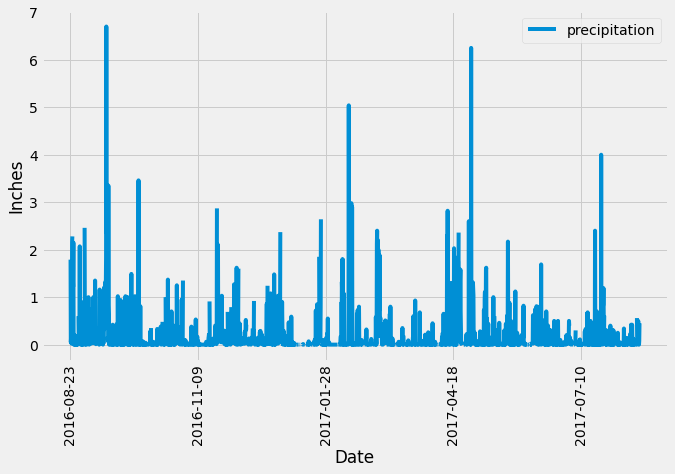

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(figsize=(10, 6), rot=90, xlabel="Date", ylabel="Inches")

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data

df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number stations in the dataset

stations1 = session.query(Station.station).distinct().count()
print(stations1)

9


In [27]:
stations2 = session.query(Measurement.station).distinct().count()
print(stations2)

9


In [28]:
station_lst = session.query(Station.station).distinct().all()
# print(station_lst)

new_lst = [station[0] for station in station_lst]

print(f"STATIONS: \n\n{new_lst}")

STATIONS: 

['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948', 'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918', 'USC00516128']


In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

newer_lst = []

for station in new_lst:
    cnt = session.query(Measurement.station).filter(Measurement.station == station).count()
    newer_lst.append((cnt, station))
    
newer_lst = sorted(newer_lst, reverse=True)

for data in newer_lst:
    print(f"Station: {data[1]}")
    print(f"Row Count: {data[0]}\n")    
    


Station: USC00519281
Row Count: 2772

Station: USC00519397
Row Count: 2724

Station: USC00513117
Row Count: 2709

Station: USC00519523
Row Count: 2669

Station: USC00516128
Row Count: 2612

Station: USC00514830
Row Count: 2202

Station: USC00511918
Row Count: 1979

Station: USC00517948
Row Count: 1372

Station: USC00518838
Row Count: 511



In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = newer_lst[0][1]
most_active_station_rows = newer_lst[0][0]


print(f"Most active station: {most_active_station}")
print(f"Observation count: {most_active_station_rows}")


sel = [Measurement.tobs,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)
       ]

results = session.query(*sel).filter(Measurement.station == most_active_station).first()

print(f"\nMIN temp: {results[1]} degrees F")
print(f"MAX temp: {results[2]} degrees F")
print(f"AVG temp: {round(results[3], 2)} degrees F")

Most active station: USC00519281
Observation count: 2772

MIN temp: 54.0 degrees F
MAX temp: 85.0 degrees F
AVG temp: 71.66 degrees F


In [36]:
results = session.query(*sel).filter(Measurement.station == most_active_station).all()
print(results)


[(85.0, 54.0, 85.0, 71.66378066378067)]


2017-08-18


<Figure size 576x432 with 0 Axes>

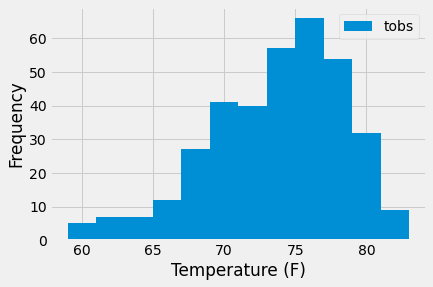

<Figure size 576x432 with 0 Axes>

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

dates = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station)

# print(dates.all())

max_date = convert_from_iso(max(dates)[0])

print(max_date)

last_12_months = max_date - relativedelta(months=12)

# print(last_12_months)

results = dates.filter(Measurement.date >= last_12_months).all()

# print(results)

df = pd.DataFrame(data=results)

df = df.set_index(keys="date")

df.plot.hist(bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.figure(figsize=(8,6))

In [32]:
# Calculate the date one year from the last date in data set.

plus_one_yr = max_date + relativedelta(years=1)

print(plus_one_yr)

2018-08-18


# Close session

In [33]:
# Close Session
session.close()